<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-исходных-данных-на-выборки" data-toc-modified-id="Разделение-исходных-данных-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение исходных данных на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Матрица-ошибок" data-toc-modified-id="Матрица-ошибок-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Матрица ошибок</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов банка

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель проекта** – подготовить прототип модели машинного обучения, предсказывающей уйдёт клиент от оператора связи в ближайшее время или нет. Требуется построить модель со значением метрики *AUC-ROC* не менее 0.59.

**Задачи:**

1. Составить план работы.
2. Уточнить задачу.
3. Разработать модель.
4. Подготовить отчёт.

**Описание данных**

**Признаки**

* `RowNumber` — индекс строки в данных,
* `CustomerId` — уникальный идентификатор клиента,
* `Surname` — фамилия,
* `CreditScore` — кредитный рейтинг,
* `Geography` — страна проживания,
* `Gender` — пол,
* `Age` — возраст,
* `Tenure` — сколько лет человек является клиентом банка,
* `Balance` — баланс на счёте,
* `NumOfProducts` — количество продуктов банка, используемых клиентом,
* `HasCrCard` — наличие кредитной карты,
* `IsActiveMember` — активность клиента,
* `EstimatedSalary` — предполагаемая зарплата.

**Целевой признак**

* `Exited` — факт ухода клиента.

## Подготовка данных

In [1]:
# импортирование необходимых библиотек
import re

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   FunctionTransformer)
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.metrics import (roc_auc_score, 
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Проведем некоторые начальные настройки и приготовления

In [2]:
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 45)
pd.set_option("display.max_rows", 300)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
%matplotlib inline

sns.set(style="whitegrid")

In [4]:
# объявление констант
RANDOM_STATE = 271123

In [5]:
# загрузка данных
try:
    data = pd.read_csv('datasets/Churn.csv')
except:
    data = pd.read_csv('E:/ЯП/Курс_спец_Data_Science/7_Обучение с учителем/Churn.csv')

In [6]:
# вывод первых 3 строк датафрейма
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1


Общая информация о датафрейме

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Список основных описательных статистик

In [8]:
data.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00",10000,"10,000.00",10000,10000,"10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"5,000.50","15,690,940.57",NaN,650.53,NaN,NaN,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",NaN,96.65,NaN,NaN,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",NaN,350.00,NaN,NaN,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",NaN,584.00,NaN,NaN,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",NaN,652.00,NaN,NaN,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",NaN,718.00,NaN,NaN,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00


In [9]:
# проверка на явные дубликаты
data.duplicated().sum()

0

Попробуем найти бесполезные переменные, т. е. переменные с одним уникальным значением и категориальные переменные, у которых категорий столько же, сколько уникальных значений.

In [10]:
pd.DataFrame({'type': data.dtypes, 'n_uniq': data.nunique()})

,type,n_uniq
RowNumber,int64,10000
CustomerId,int64,10000
Surname,object,2932
CreditScore,int64,460
Geography,object,3
Gender,object,2
Age,int64,70
Tenure,float64,11
Balance,float64,6382
NumOfProducts,int64,4


- Названия столбцов не в нотации snake_case
- На целевую переменную не влияют столбцы `RowNumber`, `CustomerId` (состоят из уникальных значений) и `Surname` (неинформативный)
- Есть пропуски (колонкa `Tenure`)
- Типы переменных в колонках соответствуют описанию данных за исключением столбца `Tenure` - значения должны быть целочисленными.
- Нет явных дубликатов

In [11]:
# приведение названий колонок к регистру snake_case
columns = [re.sub('([a-z0-9])([A-Z]+)', r'\1_\2', x).lower() for x in data.columns.values]
# присваивание столбцам отформатированных названий
data.columns = columns

In [12]:
data = data.drop(columns=['row_number', 'customer_id', 'surname'])

Выведем частоты категорий по категориальным переменным (в процентах)

In [13]:
cat_cols = [
    "geography",
    "gender",
    "tenure",
    "num_of_products",
    "has_cr_card",
    "is_active_member",
    "exited",
]
for col in cat_cols:
    print(data[col].value_counts(dropna=False, normalize=True) * 100)
    print('')

geography
France    50.14
Germany   25.09
Spain     24.77
Name: proportion, dtype: float64

gender
Male     54.57
Female   45.43
Name: proportion, dtype: float64

tenure
1.00    9.52
2.00    9.50
8.00    9.33
3.00    9.28
5.00    9.27
7.00    9.25
NaN     9.09
4.00    8.85
9.00    8.82
6.00    8.81
10.00   4.46
0.00    3.82
Name: proportion, dtype: float64

num_of_products
1   50.84
2   45.90
3    2.66
4    0.60
Name: proportion, dtype: float64

has_cr_card
1   70.55
0   29.45
Name: proportion, dtype: float64

is_active_member
1   51.51
0   48.49
Name: proportion, dtype: float64

exited
0   79.63
1   20.37
Name: proportion, dtype: float64



- `geography` — содежит три уникальных значения (France - 50%, Germany - 25%, Spain - 25%)
- `gender` — содежит два уникальных значения (Male - 54%, Female - 45%)
- `tenure` — содержит 9.1% пропусков (заполним значением вне диапазона `-1`, будет отдельной категорией), значения почти равномерно распределены в диапазоне от 0 до 10 лет
- `num_of_products` — содержит 4 уникальных значения (1 - 50%, 2 - 45%, 3 - 2.7%, 4 - 0.6%)
- `has_cr_card` — содежит два уникальных значения (1 - 70.5%, 0 - 29.5%)
- `is_active_member` — содежит два уникальных значения (1 - 51.5%, 0 - 48.5%)
- `estimated_salary` — находится в диапазоне от 0 до 200 тысяч (равномерное распределение)
- `exited` — содежит два уникальных значения (1 - 20.4%, 0 - 79.6%). Наблюдается дисбаланс классов у целевой переменной

In [14]:
# заполним пропуски значением вне диапазона и изменим тип на int
data['tenure'] = data['tenure'].fillna(-1).astype('int')

Посмотрим на распределения количественных переменных

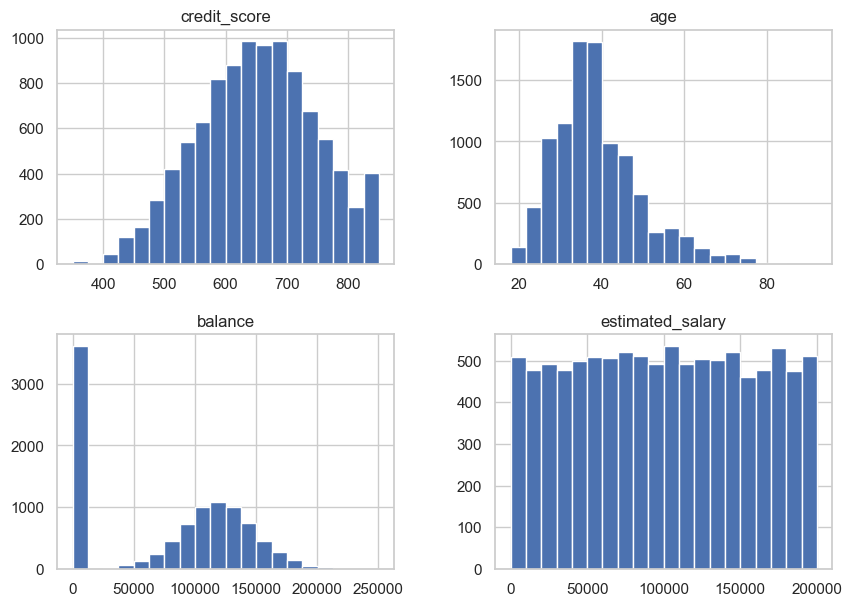

In [15]:
# общая гистограмма для количественных признаков
data[['credit_score', 'age', 'balance', 'estimated_salary']].hist(figsize=(10, 7), bins=20);

In [16]:
data[['credit_score', 'age', 'balance', 'estimated_salary']].describe()

,credit_score,age,balance,estimated_salary
count,"10,000.00","10,000.00","10,000.00","10,000.00"
mean,650.53,38.92,"76,485.89","100,090.24"
std,96.65,10.49,"62,397.41","57,510.49"
min,350.00,18.00,0.00,11.58
25%,584.00,32.00,0.00,"51,002.11"
50%,652.00,37.00,"97,198.54","100,193.91"
75%,718.00,44.00,"127,644.24","149,388.25"
max,850.00,92.00,"250,898.09","199,992.48"


In [17]:
print(f'Для клиентов с нулевым остатком на балансе: {(data["balance"] == 0).sum() / data.shape[0]}')

Для клиентов с нулевым остатком на балансе: 0.3617


- `credit_score` — значения находятся в диапазоне от 350 до 850 (похоже на нормальное распределение)
- `age` —  значения находятся в диапазоне от 18 до 92 лет (похоже на нормальное распределение, с длинным хвостом справа)
- `balance` — у 36% клиентов нулевой остаток на балансе у остальных находится в диапазоне от 50 до 200 тысяч (нормально распределено)
- `estimated_salary` — находится в диапазоне от 0 до 200 тысяч (равномерное распределение)

In [18]:
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2,"125,510.82",1,1,1,"79,084.10",0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,"96,270.64",0
9996,516,France,Male,35,10,"57,369.61",1,1,1,"101,699.77",0
9997,709,France,Female,36,7,0.00,1,0,1,"42,085.58",1
9998,772,Germany,Male,42,3,"75,075.31",2,1,0,"92,888.52",1


In [19]:
interval_cols = [
    "credit_score",
    "age",
    "tenure",
    "balance",
    "num_of_products",
    "estimated_salary",
]
phik_overview = data.phik_matrix(interval_cols=interval_cols)

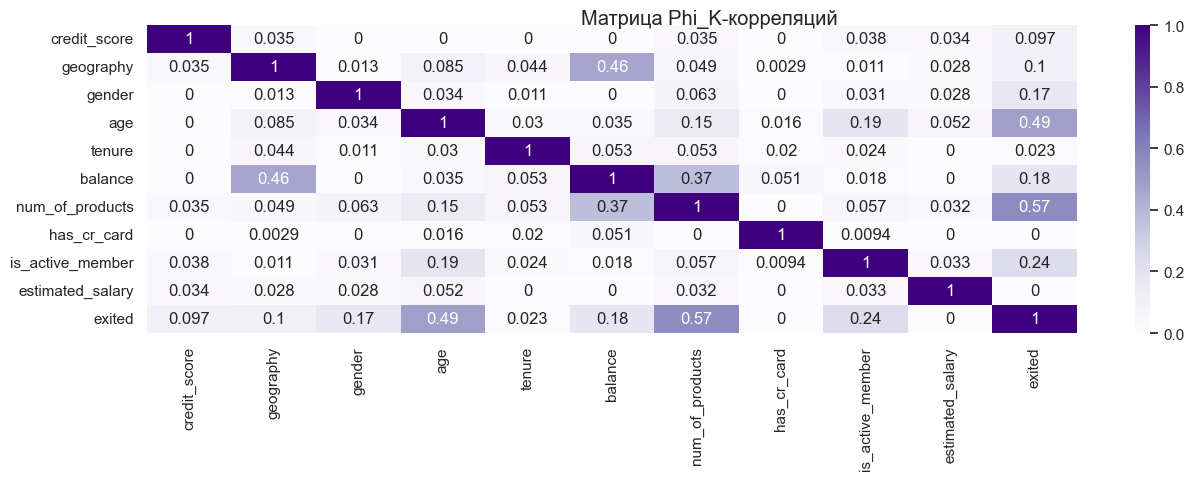

In [20]:
fig = plt.figure(figsize=(15,4))
sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True)
plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [21]:
# корреляция с целевым признаком
phik_overview['exited'].sort_values(ascending=False).to_frame()

,exited
exited,1.00
num_of_products,0.57
age,0.49
is_active_member,0.24
balance,0.18
gender,0.17
geography,0.10
credit_score,0.10
tenure,0.02
has_cr_card,0.00


Мультиколлинеарность между признаками не наблюдается

## Построение моделей

### Разделение исходных данных на выборки

Сохраним в отдельные переменные признаки и целевой признак.

In [22]:
# целевой признак
y = data["exited"]
# признаки
features = data.drop(["exited"], axis=1)

Создаем список категориальных признаков и список количественных признаков

In [23]:
num_columns = ['credit_score', 'age', 'balance', 'estimated_salary']
cat_columns = [name for name in features.columns if name not in num_columns]

In [24]:
# изменение порядка следования столбцов
features = features[num_columns + cat_columns]

In [25]:
features.head(2)

,credit_score,age,balance,estimated_salary,geography,gender,tenure,num_of_products,has_cr_card,is_active_member
0,619,42,0.00,"101,348.88",France,Female,2,1,1,1
1,608,41,"83,807.86","112,542.58",Spain,Female,1,1,0,1


В случае CatBoostClassifier пропустим шаги 'preprocessor__encoder' и 'preprocessor__scaler', а также 'feature_select', т.к. SelectKBest не принимает столбцы типа object. Параметру cat_features передадим индексы столбцов cat_indexes. Можно передать и список названий столбцов.
    
В случае LGBMClassifier пропустим также шаги кодирования и масштабирования. Но нужно привести категориальные признаки к типу 'category', чтобы потом параметру categorical_feature передать названия соответствующих колонок. Т.к. придется пройти через 'preprocessor', в названиях колонок появятся префиксы, и поменяется порядок следования столбцов в соответсвии с шагами пайплайна. Поэтому выше изменили порядок колонок в таблице с признаками в соответствии с шагами пайплайна, и обращаемся по индексам cat_indexes к категориальным признакам.

In [26]:
# индексы колонок с категориальными признаками
cat_indexes = [i for i in range(len(num_columns), len(features.columns))]

In [27]:
# check
features.iloc[:, cat_indexes].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   geography         10000 non-null  object
 1   gender            10000 non-null  object
 2   tenure            10000 non-null  int32 
 3   num_of_products   10000 non-null  int64 
 4   has_cr_card       10000 non-null  int64 
 5   is_active_member  10000 non-null  int64 
dtypes: int32(1), int64(3), object(2)
memory usage: 429.8+ KB


В дальнейшем подбор гиперпараметров планируется выполнять автоматически с помощью `RandomizedSearchCV` (поиск по сетке, контроль качества осуществляется по технике кросс-валидации). Поэтому разобьем данные на 2 части - обучающую и тестовую выборки в соотношении 3:1.

Пропорцию классов при разделении будем задавать в соответствии с распределением по классам в целевом признаке `y`.

In [28]:
# выделение обучающей выборки (75 %) и тестовой (25 %)
X_train, X_test, y_train, y_test = train_test_split(
    features,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

In [29]:
# check
display(y.value_counts(normalize=True).to_frame())
display(y_train.value_counts(normalize=True).to_frame())
display(y_test.value_counts(normalize=True).to_frame())

,proportion
exited,
0,0.80
1,0.20


,proportion
exited,
0,0.80
1,0.20


,proportion
exited,
0,0.80
1,0.20


### Обучение моделей

Мы решаем задачу классификации, в качестве моделей обучения будем использовать `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier` и `LGBMClassifier`. Подбирать гиперпараметры классификаторов с наилучшей метрикой качества *ROC-AUC* будем с помощью `RandomizedSearchCV`.

В датафрейме присутсвуют категориальные признаки. С помощью техник One-Hot Encoding и Ordinal Encoding преобразуем их в численные признаки.

К количественными признакам будем применять масштабирование (StandardScaler и MinMaxScaler), если того требует соответствующий алгоритм обучения.

Также попробуем использовать автоматический выбор признаков с помощью SelectKBest.

Создадим функцию, приводящую тип данных в таблице к типу 'category'. Добавим этот шаг в пайплайн.

In [30]:
def to_category(df):
    return df.astype('category')

In [31]:
ct = ColumnTransformer(
    [('scaler', StandardScaler(), num_columns),
     ('encoder', OrdinalEncoder(), cat_columns),
     ('func', FunctionTransformer(to_category), cat_indexes)])

pipe = Pipeline([('preprocessor', ct), 
                 ('feature_select', SelectKBest(score_func=mutual_info_classif)), 
                 ('clf', LogisticRegression())])

Ниже приведены уточненные гиперпараметры для моделей.

In [36]:
# создание сетки гиперпараметров
parameters = [
    {
        'clf': [LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
        'clf__C': np.concatenate((np.linspace(0.0001, 1, 50), np.linspace(2, 100, 20))),
        'clf__solver': ['saga', 'liblinear'],
        'clf__penalty': ['l2', 'l1'],
        'preprocessor__encoder': [OneHotEncoder(drop='first', sparse_output=False)],
        'preprocessor__scaler': [StandardScaler(), MinMaxScaler()],
        'preprocessor__func': ['drop'],
        'feature_select__score_func': [f_classif, mutual_info_classif],
        'feature_select__k': [10, 'all'],               
    },
    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'clf__n_estimators': range(700, 701),
        'clf__max_depth': range(4, 10),
        'preprocessor__encoder': [OrdinalEncoder()],
        'preprocessor__scaler': ['passthrough'],
        'preprocessor__func': ['drop'],
        'feature_select__score_func': [f_classif, mutual_info_classif],
        'feature_select__k' : [10, 'all']
    },   
    {
        'clf': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'clf__cat_features': [cat_indexes],
        'clf__n_estimators': range(830, 831),
        'clf__max_depth': range(4, 5),
        'clf__learning_rate': [0.1, 0.3, 0.03],
        'preprocessor': [None],
        'feature_select': [None]
    },         
    {
        'clf': [LGBMClassifier(random_state=RANDOM_STATE)],
        'clf__categorical_feature': [cat_indexes],
        'clf__max_depth': range(4, 5),
        'clf__n_estimators': range(600, 601),
        'clf__learning_rate': [0.1, 0.3, 0.03],
        'preprocessor__scaler': ['passthrough'],
        'preprocessor__encoder': ['drop'],
        'preprocessor__func': [FunctionTransformer(to_category)],
        'feature_select': [None]
    }         
]

In [37]:
# список с названиями моделей
model_list = ['LogisticRegression', 
              'RandomForestClassifier', 
              'CatBoostClassifier', 
              'LGBMClassifier']

In [38]:
%%time

# таблица с построенными моделями
results = []

# обучение нескольких классификаторов, сохранение результатов
for params, model_name in zip(parameters, model_list):
    # создание экземпляра RandomizedSearchCV
    rs = RandomizedSearchCV(
                    pipe,
                    params,
                    n_iter=30,
                    cv=5,
                    verbose=1,
                    random_state=RANDOM_STATE,
                    scoring='roc_auc',
                    n_jobs=-1,
                    error_score='raise')
    
    # запуск поиска по сетке
    rs.fit(X_train, y_train)

    # результаты кросс-валидации
    cv_results = pd.DataFrame(rs.cv_results_)
    fit_time = cv_results[cv_results['rank_test_score'] == 1]['mean_fit_time'].values[0]
    predict_time = cv_results[cv_results['rank_test_score'] == 1]['mean_score_time'].values[0]
    dict_to_add = {'модель': model_name,
                   'roc_auc': rs.best_score_,
                   'Время обучения': fit_time,
                   'Время предсказания': predict_time,
                   'rs': rs}
    results.append(dict_to_add)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Warning] categorical_feature is set=4,5,6,7,8,9, categorical_column=4,5,6,7,8,9 will be ignored. Current value: categorical_feature=4,5,6,7,8,9
[LightGBM] [Info] Number of positive: 1528, number of negative: 5972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203733 -> initscore=-1.363122
[LightGBM] [Info] Start training from score -1.363122
[LightGBM] [Warning] No further splits with po

In [39]:
results_2 = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
results_2

,модель,roc_auc,Время обучения,Время предсказания,rs
0,CatBoostClassifier,0.87,17.62,0.02,"RandomizedSearchCV(cv=5, error_score='raise',\..."
1,LGBMClassifier,0.86,0.93,0.02,"RandomizedSearchCV(cv=5, error_score='raise',\..."
2,RandomForestClassifier,0.86,10.73,0.22,"RandomizedSearchCV(cv=5, error_score='raise',\..."
3,LogisticRegression,0.83,0.06,0.01,"RandomizedSearchCV(cv=5, error_score='raise',\..."


In [40]:
# гиперпараметры CatBoostClassifier
results_2['rs'][0].best_params_

{'preprocessor': None,
 'feature_select': None,
 'clf__n_estimators': 830,
 'clf__max_depth': 4,
 'clf__learning_rate': 0.03,
 'clf__cat_features': [4, 5, 6, 7, 8, 9],
 'clf': <catboost.core.CatBoostClassifier at 0x17545237c70>}

In [41]:
# гиперпараметры LGBMClassifier
results_2['rs'][1].best_params_

{'preprocessor__scaler': 'passthrough',
 'preprocessor__func': FunctionTransformer(func=<function to_category at 0x0000017542D73AC0>),
 'preprocessor__encoder': 'drop',
 'feature_select': None,
 'clf__n_estimators': 600,
 'clf__max_depth': 4,
 'clf__learning_rate': 0.03,
 'clf__categorical_feature': [4, 5, 6, 7, 8, 9],
 'clf': LGBMClassifier(random_state=271123)}

In [44]:
# гиперпараметры RandomForestClassifier
results_2['rs'][2].best_params_

{'preprocessor__scaler': 'passthrough',
 'preprocessor__func': 'drop',
 'preprocessor__encoder': OrdinalEncoder(),
 'feature_select__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'feature_select__k': 10,
 'clf__n_estimators': 700,
 'clf__max_depth': 9,
 'clf': RandomForestClassifier(random_state=271123)}

In [45]:
# гиперпараметры LogisticRegression
results_2['rs'][3].best_params_

{'preprocessor__scaler': StandardScaler(),
 'preprocessor__func': 'drop',
 'preprocessor__encoder': OneHotEncoder(drop='first', sparse_output=False),
 'feature_select__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'feature_select__k': 10,
 'clf__solver': 'saga',
 'clf__penalty': 'l2',
 'clf__C': 0.6122836734693877,
 'clf': LogisticRegression(max_iter=1000, random_state=271123)}


На этом этапе работы:

* обучены модели классификации - логистическая регрессия, случайный лес, CatBoost и LightGBM, выбрана модель с наилучшим значением метрики качества *ROC-AUC* с помощью поиска по гиперпараметрам, ей оказалась модель **`CatBoostClassifier`** с ***ROC-AUC* = 0.87**, `max_depth=4`, `n_estimators=830`, `learning_rate=0.03`.

* Остальные модели имеют следующие гиперпараметры и метрику качества:
    * `LGBMClassifier`: ***ROC-AUC* = 0.86**, `max_depth=4`, `n_estimators=600`, `learning_rate=0.03`, 

    * `RandomForestClassifier`: ***ROC-AUC* = 0.86**, `max_depth=9`, `n_estimators=700`,

    * `LogisticRegression`: ***ROC-AUC* = 0.83**, `C=0.612`, `solver = saga`, `penalty = l2`.

Проверим качество модели, получившей лучший результат значения метрики *ROC-AUC* на кроссвалидации, на тестовой выборке.

In [47]:
roc_auc = roc_auc_score(y_test, results_2['rs'][0].predict_proba(X_test)[:, 1])
print(f'ROC-AUC наилучшей модели на тестовой выборке:{roc_auc: .2f}')

ROC-AUC наилучшей модели на тестовой выборке: 0.87


Результат работы алгоритма на тестовой выборке визуализируем с помощью ROC-кривой.

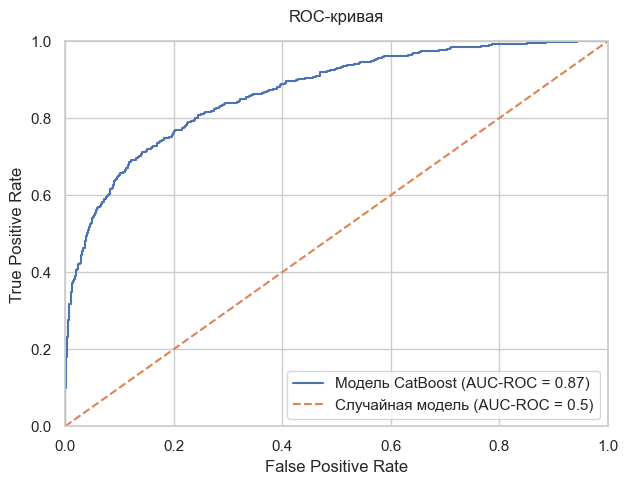

In [48]:
# значения FPR, TPR и рассмотренные пороги
fpr, tpr, thresholds = roc_curve(y_test, results_2['rs'][0].predict_proba(X_test)[:, 1])

plt.figure(figsize=(7, 5))

# построение графика ROC-кривой модели случайного леса
plt.plot(fpr, tpr, label='Модель CatBoost (AUC-ROC = %0.2f)' % roc_auc)
# построение графика ROC-кривой случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель (AUC-ROC = 0.5)')

# границы осей 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая', y=1.03)
plt.legend(loc='lower right');

Таким образом, модель `CatBoost` на тестовой выборке показала результат метрики качества ***AUC-ROC* = 0.87**, следовательно, модель адекватна, ее качество лучше, чем у случайной модели.

### Анализ важности признаков

In [50]:
importances = results_2['rs'][0].best_estimator_._final_estimator.feature_importances_
importances

array([ 5.3210898 , 25.64705743, 14.01943938,  6.0140657 ,  9.22734816,
        2.94762965,  2.70126718, 25.75955411,  0.24407889,  8.1184697 ])

In [51]:
feature_names = X_train.columns

In [52]:
importances_df = (pd.DataFrame({'feature_names': feature_names, 'importances': importances})
                  .sort_values(by='importances', ascending=False))
importances_df

,feature_names,importances
7,num_of_products,25.76
1,age,25.65
2,balance,14.02
4,geography,9.23
9,is_active_member,8.12
3,estimated_salary,6.01
0,credit_score,5.32
5,gender,2.95
6,tenure,2.70
8,has_cr_card,0.24


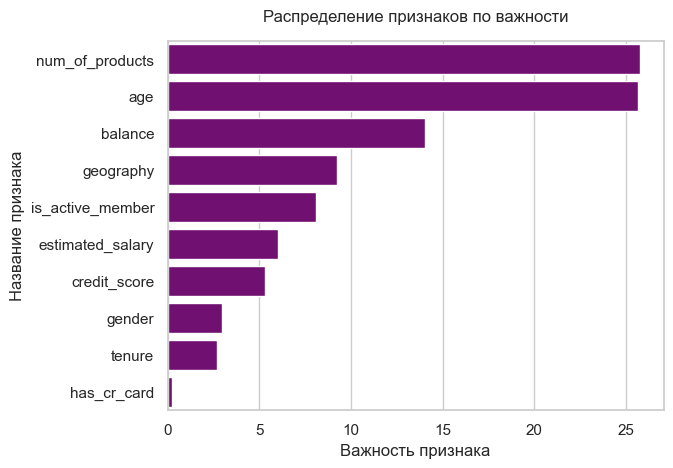

In [53]:
sns.barplot(data=importances_df, x='importances', y='feature_names', color='purple')
plt.xlabel('Важность признака')
plt.ylabel('Название признака')
plt.title('Распределение признаков по важности', y=1.03);

### Матрица ошибок

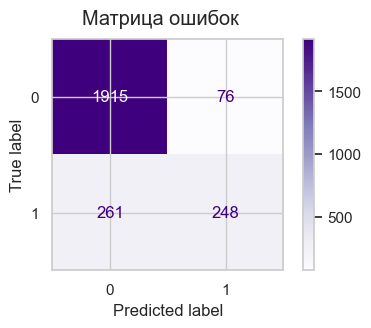

In [55]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)

ConfusionMatrixDisplay.from_estimator(results_2['rs'][0], X_test, y_test, cmap='Purples', ax=ax)
plt.suptitle('Матрица ошибок');

In [57]:
predictions_test = results_2['rs'][0].predict(X_test)
confusion_m = confusion_matrix(y_test, predictions_test)

In [58]:
tp, tn, fp, fn = confusion_m[1,1], confusion_m[0,0], confusion_m[0,1], confusion_m[1,0]

print('True Positives (TP) =', tp)
print('\nTrue Negatives (TN) =', tn)
print('\nFalse Positives (FP) =', fp)
print('\nFalse Negatives (FN) =', fn)

True Positives (TP) = 248

True Negatives (TN) = 1915

False Positives (FP) = 76

False Negatives (FN) = 261


In [59]:
print(f'Accuracy модели на тестовой выборке:{accuracy_score(y_test, predictions_test): .2f}')
print(f'\nPrecision модели на тестовой выборке:{precision_score(y_test, predictions_test): .2f}')
print(f'\nRecall модели на тестовой выборке:{recall_score(y_test, predictions_test): .2f}')

Accuracy модели на тестовой выборке: 0.87

Precision модели на тестовой выборке: 0.77

Recall модели на тестовой выборке: 0.49


## Общий вывод

Было проведено исследование, позволившее построить модель для задачи классификации, которая прогнозирует, уйдёт клиент из банка в ближайшее время или нет. Входные данные – данные о поведении клиентов и расторжении договоров с банком.

При изучении файла с данными не выявлено аномалий и существенных выбросов в признаках. В колонке `tenure` были обработаны пропущенные значения и изменен тип данных. Из датасета были удалены три признака, не несущие информацию для предсказания.

Данные были разделены на обучающую и тестовую выборки в соотношении 3:1 с учетом дисбаланса классов в целевом признаке.

Были рассмотрены 3 алгоритма обучения – градиентный бустинг, случайный лес и логистическая регрессия. В результате наилучшей оказалась модель CatBoostClassifier, с AUC-ROC - 0.87.
- гипрепараметры модели – `max_depth=4`, `n_estimators=830`, `learning_rate=0.03`

Окончательная проверка качества моделей на тестовой выборке показала значение AUC-ROC - 0.87.